# **Bird Sound Classifier**

fast.ai's courses and software make it extremely easy to start working on difficult projects very quickly. This is just another example of that.

This is a Bird Sound Classifying Deep Learning model, which takes in bird sounds, converts them into images (spectograms), and then classifies those images based on what type of bird call it is. 

The data is from: https://datadryad.org/resource/doi:10.5061/dryad.4g8b7/1

There are 6 types of bird calls: distance,hat,kackle,song,stack,tet.

This model gets around 80% accuracy, which is not bad at all for something that relies on so many different factors. 

**Libraries** 

The necessary libraries and functions have to be imported:

In [0]:
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
import librosa.display

Since this was done on Google's Colab environment, it is necessary to link up Google Drive to the project, so that the data can be imported.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'bird-recognition'

Mounted at /content/gdrive


In [0]:
path = Path(base_dir+'/wav_files_playback')

**Creating spectograms:**

Next, a very simple function, create_fold_spectrograms, which takes in the folder name as input, and creates spectrograms in corresponding folders in a seperate path. This uses the librosa package. The code is similar to the one used in: https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

In [0]:
def create_fold_spectrograms(folder):
    spectrogram_path = Path(base_dir+'/specto')  
    audio_path = path  
    os.makedirs(spectrogram_path/folder,exist_ok=True)
    for audio_file in list(Path(audio_path/f'{folder}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/folder/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [0]:
folds=['distance','hat','kackle','song','stack','tet']

In [0]:
for i in folds:
  create_fold_spectrograms(str(i))

**Data Bunch**

Once, the sound files are converted into image files, the data can be extracted from the folders and seperated into training and validation sets. 

In [0]:
np.random.seed(42)
spectrogram_path = Path(base_dir+'/specto')  
tfms = get_transforms(do_flip=False)
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(spectrogram_path, train=".", ds_tfms=tfms, valid_pct=0.2, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (152 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
distance,distance,distance,distance,distance
Path: /content/gdrive/My Drive/bird-recognition/specto;

Valid: LabelList (37 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tet,tet,distance,distance,hat
Path: /content/gdrive/My Drive/bird-recognition/specto;

Test: None

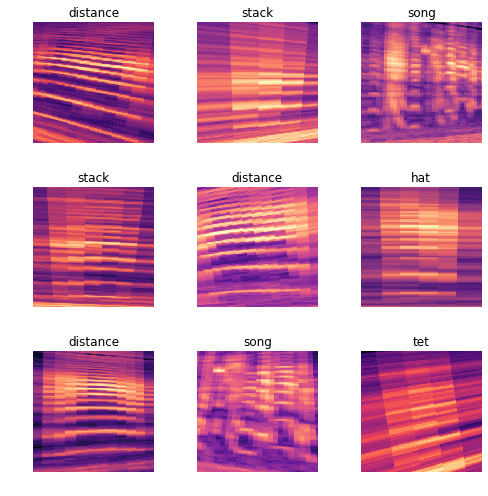

In [0]:
data.show_batch(rows=3,figsize=(7,7))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['distance', 'hat', 'kackle', 'song', 'stack', 'tet'], 6, 152, 37)

We can see that there are 6 different classes, and a good split between training and validation sets. 

**Training**

Next, cnn_learner can be used, with a resnet34 architecture, to train the model:

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 101948611.46it/s]


In [0]:
learn.fit_one_cycle(6,max_lr=slice(3e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.438323,0.588238,0.189189,0.810811,00:03
1,0.361946,0.716108,0.324324,0.675676,00:03
2,0.333349,1.141138,0.297297,0.702703,00:03
3,0.290415,1.483750,0.297297,0.702703,00:03
4,0.271594,1.513314,0.324324,0.675676,00:03
5,0.240999,1.303614,0.297297,0.702703,00:03


There's only about 70% accuracy, which can be made higher with the right learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


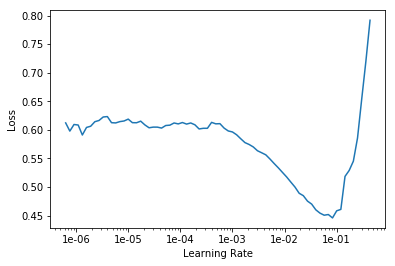

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(6,max_lr=slice(3e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.089979,1.076153,0.324324,0.675676,00:03
1,0.085291,0.820889,0.243243,0.756757,00:03
2,0.080007,0.758169,0.189189,0.810811,00:03
3,0.099773,0.824883,0.216216,0.783784,00:03
4,0.106347,0.963399,0.243243,0.756757,00:03
5,0.101405,0.916323,0.216216,0.783784,00:03


78% accuracy is the final accuracy. With some tinkering, this can be increased to slightly above 80% as well. 

**Interpreting Results:**

Using the ClassificationInterpretation function, the results of the training model can be interepreted:

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

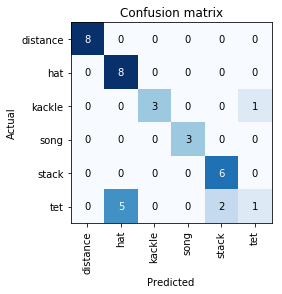

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('tet', 'hat', 5), ('tet', 'stack', 2)]

From this, it is evident that tet is the one causing the most problem, with it being misclassified 7 times, and only correctly classified once. Otherwise, the model is almost fully accurate. 